<a href="https://colab.research.google.com/github/tamimdnan6240/Convolutional-Neural-Network/blob/main/Cluster_analysis_HPMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape dropdown. After, re-execute the code cell.


Referrences:
1. https://www.linkedin.com/advice/1/what-best-practices-feature-engineering-clustering-npiuc


In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import scipy.cluster.hierarchy as hca
import pandas as pd
import numpy as np
from pylab import *
from matplotlib import pyplot
%matplotlib inline
np.set_printoptions(suppress=True)
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Data Preparation

In [5]:
# Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/HMPS-Socioeconomic_dataset/Data/FINAL DATASET/Socio-hpms.csv')
data.head(10)

<ipython-input-5-ee11e6b9a5fc>:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/HMPS-Socioeconomic_dataset/Data/FINAL DATASET/Socio-hpms.csv')


Unnamed: 0  AADT_mean  AADT_Single_Unit_mean  Year  AADT_Combination_mean  \
0           0     1395.0                  156.0  2017                   54.0   
1           1       88.0                   34.0  2017                   34.0   
2           2      415.0                  165.0  2017                  165.0   
3           3    18721.0                 2067.0  2017                  711.0   
4           4     4541.0                  390.0  2017                  123.0   
5           5    40768.0                 1581.0  2017                 5062.0   
6           6    40961.0                  820.0  2017                 2295.0   
7           7    25756.0                  489.0  2017                 1418.0   
8           8     7826.0                  125.0  2017                  697.0   
9           9     2807.0                  292.0  2017                  236.0   

   Dir_Factor_mean  Future_AADT_mean  IRI_mean  Rutting_mean  \
0             59.0            1590.0      82.0      0.000000   
1             58.9              89.0     177.0      0.000000   
2             59.0             420.0      46.0      0.000000   
3             59.0           18758.0     107.0      0.000000   
4             59.0            6560.0     138.0      0.100000   
5             57.0           47270.0      99.0      0.167131   
6             59.0           40924.0      64.0      0.167131   
7             63.0           25867.0     114.7      0.167131   
8             59.0            7837.0      96.0      0.167131   
9             63.0            3930.0     180.9      0.100000   

   Cracking_Percent_mean  Thickness_Rigid_mean  Thickness_Flexible_mean  \
0                    0.0              9.030256                 6.000000   
1                    0.0              9.030256                 6.000000   
2                    0.0              9.030256                 6.000000   
3                    0.0              8.000000                 6.000000   
4                    2.0              8.000000                 4.400000   
5                    0.0             12.000000                 6.559314   
6                    0.0             11.500000                 6.559314   
7                   83.3              8.000000                 6.559314   
8                  100.0              8.000000                 6.559314   
9                    3.8              9.030256                 3.000000   

   Base_Thickness_mean  Lane_Width_mean  Last_Overlay_Thickness_mean  \
0                 15.0             12.0                     2.000000   
1                 15.0             12.0                     2.000000   
2                 15.0             11.0                     2.000000   
3                 15.0             12.0                     2.000000   
4                 15.0             12.0                     2.000000   
5                  6.0             12.0                     3.500000   
6                 15.0             12.0                     2.848028   
7                 16.0             12.0                     2.848028   
8                 16.0             12.0                     2.848028   
9                  8.0             11.0                     1.500000   

   F_System_mode  Urban_Code_mode  Through_Lanes_mode  Surface_Type_mode  \
0              5          99999.0                   2                  6   
1              4          93025.0                   2                  2   
2              5          99999.0                   2                  2   
3              5          99999.0                   2                  7   
4              4          45910.0                   2                  7   
5              1          45910.0                   4                  3   
6              1          47719.0                   4                  3   
7              2          47719.0                   4                  3   
8              2          99999.0                   4                  3   
9              3          40429.0     

In [6]:
#move column 'Year' to the beginning for creating better correlation of the features
data = data[['Year'] + [col for col in data.columns if col != 'Year']]

In [7]:
data.columns

Index(['Year', 'Unnamed: 0', 'AADT_mean', 'AADT_Single_Unit_mean',
       'AADT_Combination_mean', 'Dir_Factor_mean', 'Future_AADT_mean',
       'IRI_mean', 'Rutting_mean', 'Cracking_Percent_mean',
       'Thickness_Rigid_mean', 'Thickness_Flexible_mean',
       'Base_Thickness_mean', 'Lane_Width_mean', 'Last_Overlay_Thickness_mean',
       'F_System_mode', 'Urban_Code_mode', 'Through_Lanes_mode',
       'Surface_Type_mode', 'Base_Type_mode', 'County_Code_mode',
       'State_Code_mode', 'Year_Last_Improv_mode',
       'Year_Last_Construction_mode', 'RHU_AV', 'RHU_AV_MN', 'RHU_AV_MX',
       'ALBEDO_AVG', 'CLD_CVR_AV', 'EMISSIVITY', 'EMIS_AVG', 'PER_SUN_AV',
       'SW_SF_AVG', 'SW_SF_STDV', 'SW_SURFACE', 'SW_TOA', 'DAYS_A_32C',
       'DAYS_BL_0C', 'FRZ_IDX', 'FRZ_THAW', 'SOIL_TL1AV', 'SOIL_TL2AV',
       'TEMP_AVG', 'TEMP_MAX', 'TEMP_MIN', 'AVG_WND_VEL_AV', 'AVG_WND_VEL_MX',
       'PRECIPITATION', 'EVAPORATION', 'hzdepb_r_mean', 'sieveno4_r_mean',
       'sieveno10_r_mean', 'sieveno

Here,
1. 'RHU_AV' - Annual average daily average relative humidity,
2. 'RHU_AV_MN' - Annual average daily minimum relative humidity ,
3. 'RHU_AV_MX' - Annual average daily maximum relative humidity ,
4. 'ALBEDO_AVG' - Annual average surface albedo,
5. 'CLD_CVR_AV' - Annual average cloud cover ,
6. 'EMISSIVITY' - Annual average surface emissivity,
7. 'EMIS_AVG', - Annual average surface emissivity,
8. 'PER_SUN_AV', - Annual average sunshine fraction,
9. 'SW_SF_AVG', - Annual average downward net surface shortwave flux
10. 'SW_SF_STDV',
11. 'SW_SURFACE',
12. 'SW_TOA', - Annual average top of atmosphere net downward shortwave flux
13. 'DAYS_A_32C',- Annual number of days with temperature above 32◦C
14. 'DAYS_BL_0C', - Average annual number of days with temperature below 0◦C
15. 'FRZ_IDX', - Annual average freezing index
16. 'FRZ_THAW', - Average number of annual freeze–thaw cycles
17. 'SOIL_TL1AV', - Annual average soil temperature (0 to 100 mm)
18. 'SOIL_TL2AV', - Annual average soil temperature (100 to 400 mm)
19. 'TEMP_AVG', - Annual average daily average temperature
20. 'TEMP_MAX', - Annual average daily maximum temperature
21. 'TEMP_MIN', - Annual average daily minimum temperature
22. 'AVG_WND_VEL_AV', - Annual average daily average wind speed, 2 m above ground surface
23. 'AVG_WND_VEL_MX', - Annual average daily maximum wind speed, 2 m above ground surface
24.  'PRECIPITATION',
25.  'EVAPORATION',

26.'hzdepb_r_mean', - Soil horizon/strata depth,
27. 'sieveno4_r_mean', - Percent passing No. 4 sieve size
28. 'sieveno10_r_mean', - Percent passing No. 10 sieve size
29. 'sieveno40_r_mean',- Percent passing No. 40 sieve size
30. 'sieveno200_r_mean',
31. 'sandtotal_r_mean',
32. 'sandfine_r_mean',
33.  'silttotal_r_mean', - Percent silt fraction
35. 'claytotal_r_mean',-  Percent clay fraction
36. 'll_r_mean', - Soil liquid limit
38. 'pi_r_mean', - Soil plasticity index

39. 'DAYS_BL_0C' - Average annual number of days with temperature below 0◦C

In [8]:
## dropping redunanant columns
data.drop(['Unnamed: 0', 'AADT_Single_Unit_mean','AADT_Combination_mean', 'Dir_Factor_mean', 'Thickness_Rigid_mean', 'Thickness_Flexible_mean',
       'Base_Thickness_mean', 'Last_Overlay_Thickness_mean', 'Urban_Code_mode', 'Through_Lanes_mode', 'Base_Type_mode', 'County_Code_mode',
       'State_Code_mode', 'Year_Last_Improv_mode',
        'RHU_AV_MN', 'RHU_AV_MX',
       'ALBEDO_AVG', 'EMISSIVITY'], axis=1, inplace=True)

In [9]:
data.shape

(65201, 62)

In [10]:
## Convert all columns to numeric
data = data.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [11]:
print(data.shape)
data.dtypes

(65201, 62)


Year                                                                                                        int64
AADT_mean                                                                                                 float64
Future_AADT_mean                                                                                          float64
IRI_mean                                                                                                  float64
Rutting_mean                                                                                              float64
Cracking_Percent_mean                                                                                     float64
Lane_Width_mean                                                                                           float64
F_System_mode                                                                                               int64
Surface_Type_mode                                                                       

In [12]:
#count cells percolumns
# print(data.count())

In [13]:
# notice there are null
data.isnull().any()

Year                                                                                                      False
AADT_mean                                                                                                 False
Future_AADT_mean                                                                                          False
IRI_mean                                                                                                  False
Rutting_mean                                                                                              False
Cracking_Percent_mean                                                                                     False
Lane_Width_mean                                                                                           False
F_System_mode                                                                                             False
Surface_Type_mode                                                                                       

In [14]:
data.drop(['Year_Last_Construction_mode', 'GEO_ID'], axis=1, inplace=True)

In [15]:
data.shape

(65201, 60)

## Feature Engineering

1. Find correlation between the columns then you can remove the very correlated columns as needed.  (use pearson correlation).

2. Detect the oultiers with data.secrbie, boxplot and other methods if needed.

3. Scale the data

4. Check the data with pairwise distribution

Pearson correlations
Understand from
1. https://www.geeksforgeeks.org/exploring-correlation-in-python/
2. https://medium.com/@chandradip93/all-about-feature-selec-e6e88e8ccd46

In [16]:
## calculate correlations in different times.

def calculate_corr(df):
  data_corr_ = df.corr(method = 'pearson') ## import pandas if needed.
  return data_corr_

## This function will return that which columns are correlated with a specific thresholds.
def calculate_corr_columns (df, threshold_value):
  data_corr_ = df.corr(method = 'pearson') ## import pandas if needed.

  find_corr_columns = []

  ## now calculate that # 'f' now contains the indices of rows where any off-diagonal value is greater than a specific values.
  for index, row in data_corr_.iterrows():  # Iterate over rows
    # Check if any value in the row (excluding the diagonal) is greater than 0.90
    # Diagonal values can be excluded by masking or other logic, depending on the structure of your DataFrame
    # Assuming the correlation matrix is square and indexed similarly to columns:
    value = row[row.index != index] > threshold_value
    if value.any():  # If any value in 'value' is True (excluding diagonal), proceed
        find_corr_columns .append(index)  # Append the row index (label) where the condition is met
  ## This function will return that which columns are correlated with a specific thresholds.

  ## Now check pearson correlation just for seeing the values
  # use heatmap for presenting the correlations
  plt.figure(figsize= (30, 18))
  corre_matrix = sns.heatmap(data_corr_[find_corr_columns], annot=True, linewidth=.5)
  return find_corr_columns, corre_matrix

(['AADT_mean',
  'Future_AADT_mean',
  'PER_SUN_AV',
  'SW_SF_AVG',
  'SW_SURFACE',
  'SW_TOA',
  'DAYS_BL_0C',
  'FRZ_THAW',
  'SOIL_TL1AV',
  'SOIL_TL2AV',
  'TEMP_AVG',
  'TEMP_MIN',
  'AVG_WND_VEL_AV',
  'AVG_WND_VEL_MX',
  'sieveno4_r_mean',
  'sieveno10_r_mean',
  'sieveno40_r_mean',
  'sandtotal_r_mean',
  'sandfine_r_mean',
  'claytotal_r_mean',
  'pi_r_mean',
  'Total Population_x',
  'Male',
  'Female',
  'Median Age',
  'Median Ages for Men',
  'Median Ages for Women',
  'Speak a language other than English on Population 5 years and over',
  'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Spanish on Population 5 years and over',
  'White Alone'],
 <Axes: >)

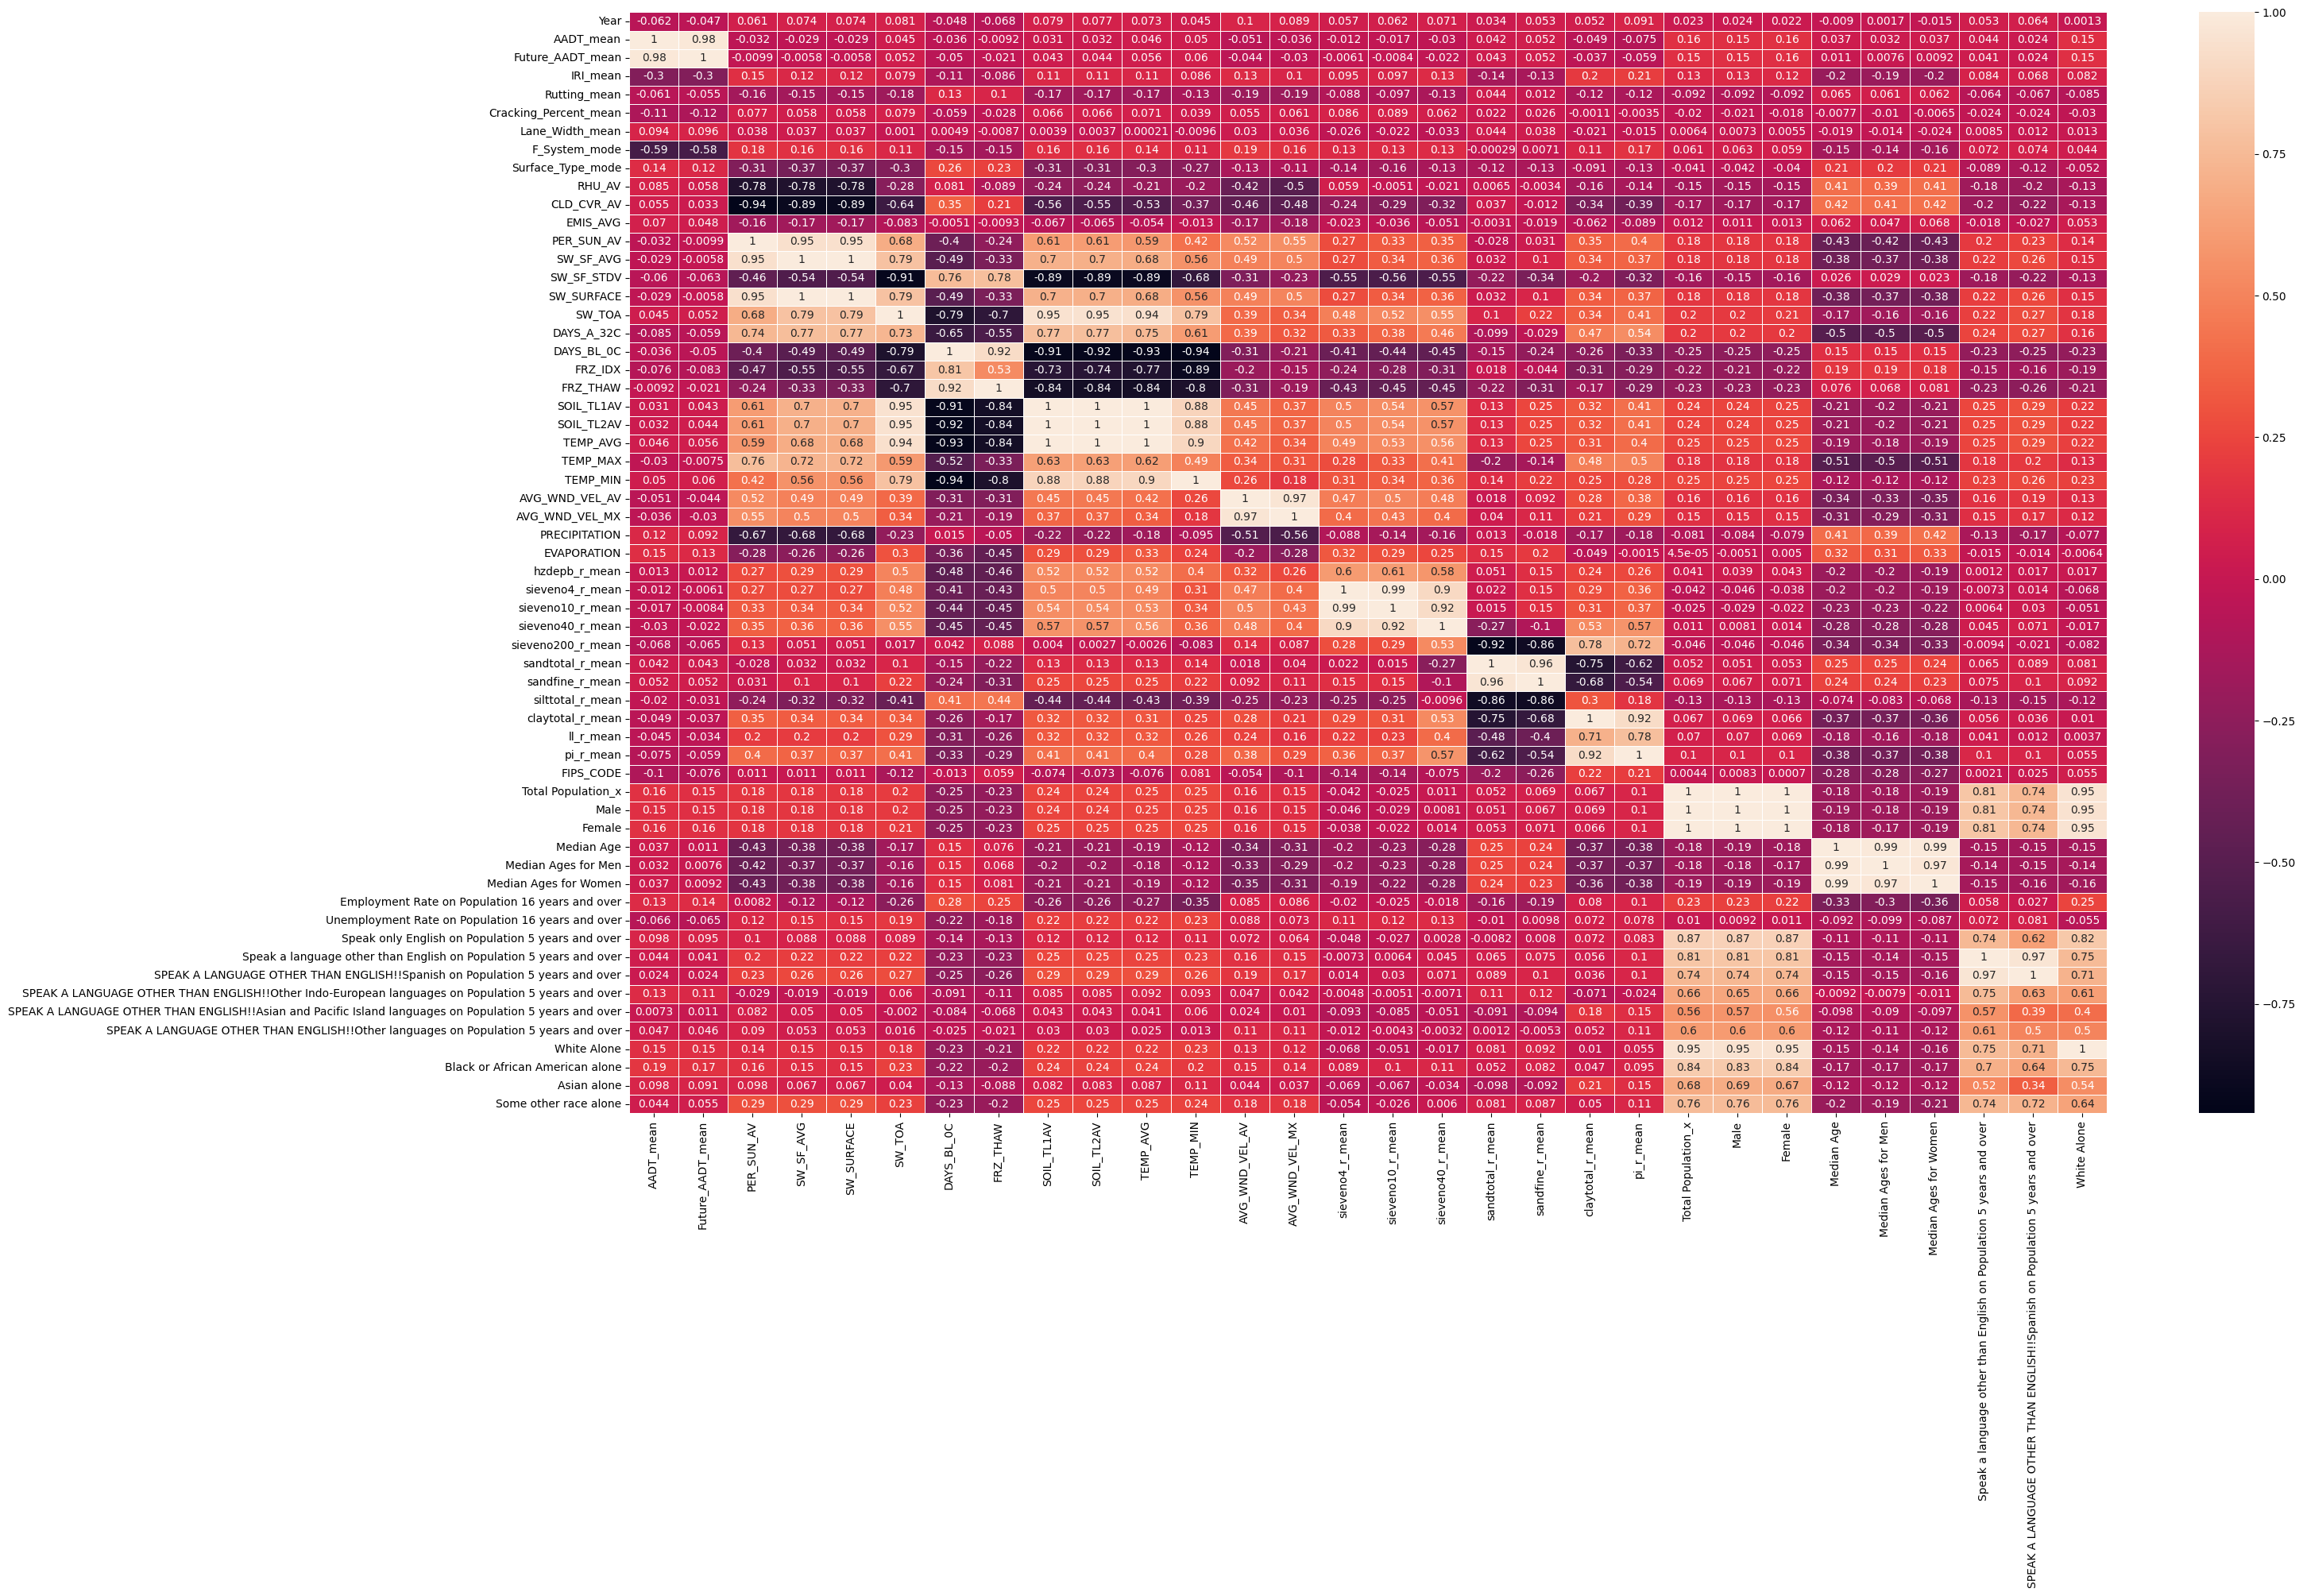

In [17]:
calculate_corr_columns (data, 0.90)

In [18]:
to_drop = [ 'Future_AADT_mean', 'PER_SUN_AV','SW_SURFACE','SW_TOA','FRZ_THAW', 'SOIL_TL1AV',
 'SOIL_TL2AV','TEMP_MIN','AVG_WND_VEL_AV',  'sieveno4_r_mean',
 'sieveno10_r_mean',  'sandfine_r_mean', 'pi_r_mean','Total Population_x','Male', 'Female', 'Median Ages for Men', 'Median Ages for Women', 'Speak a language other than English on Population 5 years and over']

data.drop(to_drop, axis=1, inplace=True)

In [19]:
data.shape

(65201, 41)

In [20]:
data.columns

Index(['Year', 'AADT_mean', 'IRI_mean', 'Rutting_mean',
       'Cracking_Percent_mean', 'Lane_Width_mean', 'F_System_mode',
       'Surface_Type_mode', 'RHU_AV', 'CLD_CVR_AV', 'EMIS_AVG', 'SW_SF_AVG',
       'SW_SF_STDV', 'DAYS_A_32C', 'DAYS_BL_0C', 'FRZ_IDX', 'TEMP_AVG',
       'TEMP_MAX', 'AVG_WND_VEL_MX', 'PRECIPITATION', 'EVAPORATION',
       'hzdepb_r_mean', 'sieveno40_r_mean', 'sieveno200_r_mean',
       'sandtotal_r_mean', 'silttotal_r_mean', 'claytotal_r_mean', 'll_r_mean',
       'FIPS_CODE', 'Median Age',
       'Employment Rate on Population 16 years and over',
       'Unemployment Rate on Population 16 years and over',
       'Speak only English on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Spanish on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Other Indo-European languages on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Asian and Pacific Island languages on Population 5 years and o

So, featured variables are found. But for this research some less prioritized columns are here. so exclude them.
'hzdepb_r_mean', 'sieveno40_r_mean', 'sieveno200_r_mean',
       'sandtotal_r_mean', 'silttotal_r_mean', 'claytotal_r_mean', 'll_r_mean',

'CLD_CVR_AV' - Annual average cloud cover ,
'SW_SF_STDV'


In [21]:
to_drop_2 = ['CLD_CVR_AV','SW_SF_AVG', 'DAYS_A_32C','hzdepb_r_mean', 'sieveno40_r_mean', 'sieveno200_r_mean', 'sandtotal_r_mean', 'silttotal_r_mean', 'claytotal_r_mean', 'll_r_mean']

data.drop(to_drop_2 , axis=1, inplace=True)

In [22]:
data.shape

(65201, 31)

In [23]:
data.columns

Index(['Year', 'AADT_mean', 'IRI_mean', 'Rutting_mean',
       'Cracking_Percent_mean', 'Lane_Width_mean', 'F_System_mode',
       'Surface_Type_mode', 'RHU_AV', 'EMIS_AVG', 'SW_SF_STDV', 'DAYS_BL_0C',
       'FRZ_IDX', 'TEMP_AVG', 'TEMP_MAX', 'AVG_WND_VEL_MX', 'PRECIPITATION',
       'EVAPORATION', 'FIPS_CODE', 'Median Age',
       'Employment Rate on Population 16 years and over',
       'Unemployment Rate on Population 16 years and over',
       'Speak only English on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Spanish on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Other Indo-European languages on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Asian and Pacific Island languages on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Other languages on Population 5 years and over',
       'White Alone', 'Black or African American alone', 'Asian alone',
       'Some other ra

# Select Dataset for trend Analysis

## Filter dataset year by Year

In [24]:
df_2017 = data[data['Year'] == 2017]
df_2018 = data[data['Year'] == 2018]
df_2019 = data[data['Year'] == 2019]
df_2020 = data[data['Year'] == 2020]

print(df_2017.shape)
print(df_2018.shape)
print(df_2019.shape)
print(df_2020.shape)

# Check whether there are any null values there
data.isnull().any(axis=1)

(14584, 31)
(9438, 31)
(20470, 31)
(20709, 31)


0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
30       False
31       False
32       False
33       False
34       False
35       False
36       False
37       False
38       False
39       False
40       False
41       False
42       False
43       False
44       False
45       False
46       False
47       False
48       False
49       False
50       False
51       False
52       False
53       False
54       False
55       False
56       False
57       False
58       False
59       False
60       False
61       False
62       False
63       False
64       False
65       False
66       F

# Outlier Detection

Read this:
1. https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8

2. https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

3. https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/#:~:text=Step%203%3A%20Mean%2FMedian%20Imputation,outliers%20with%20the%20median%20value.

4. https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

First 2017

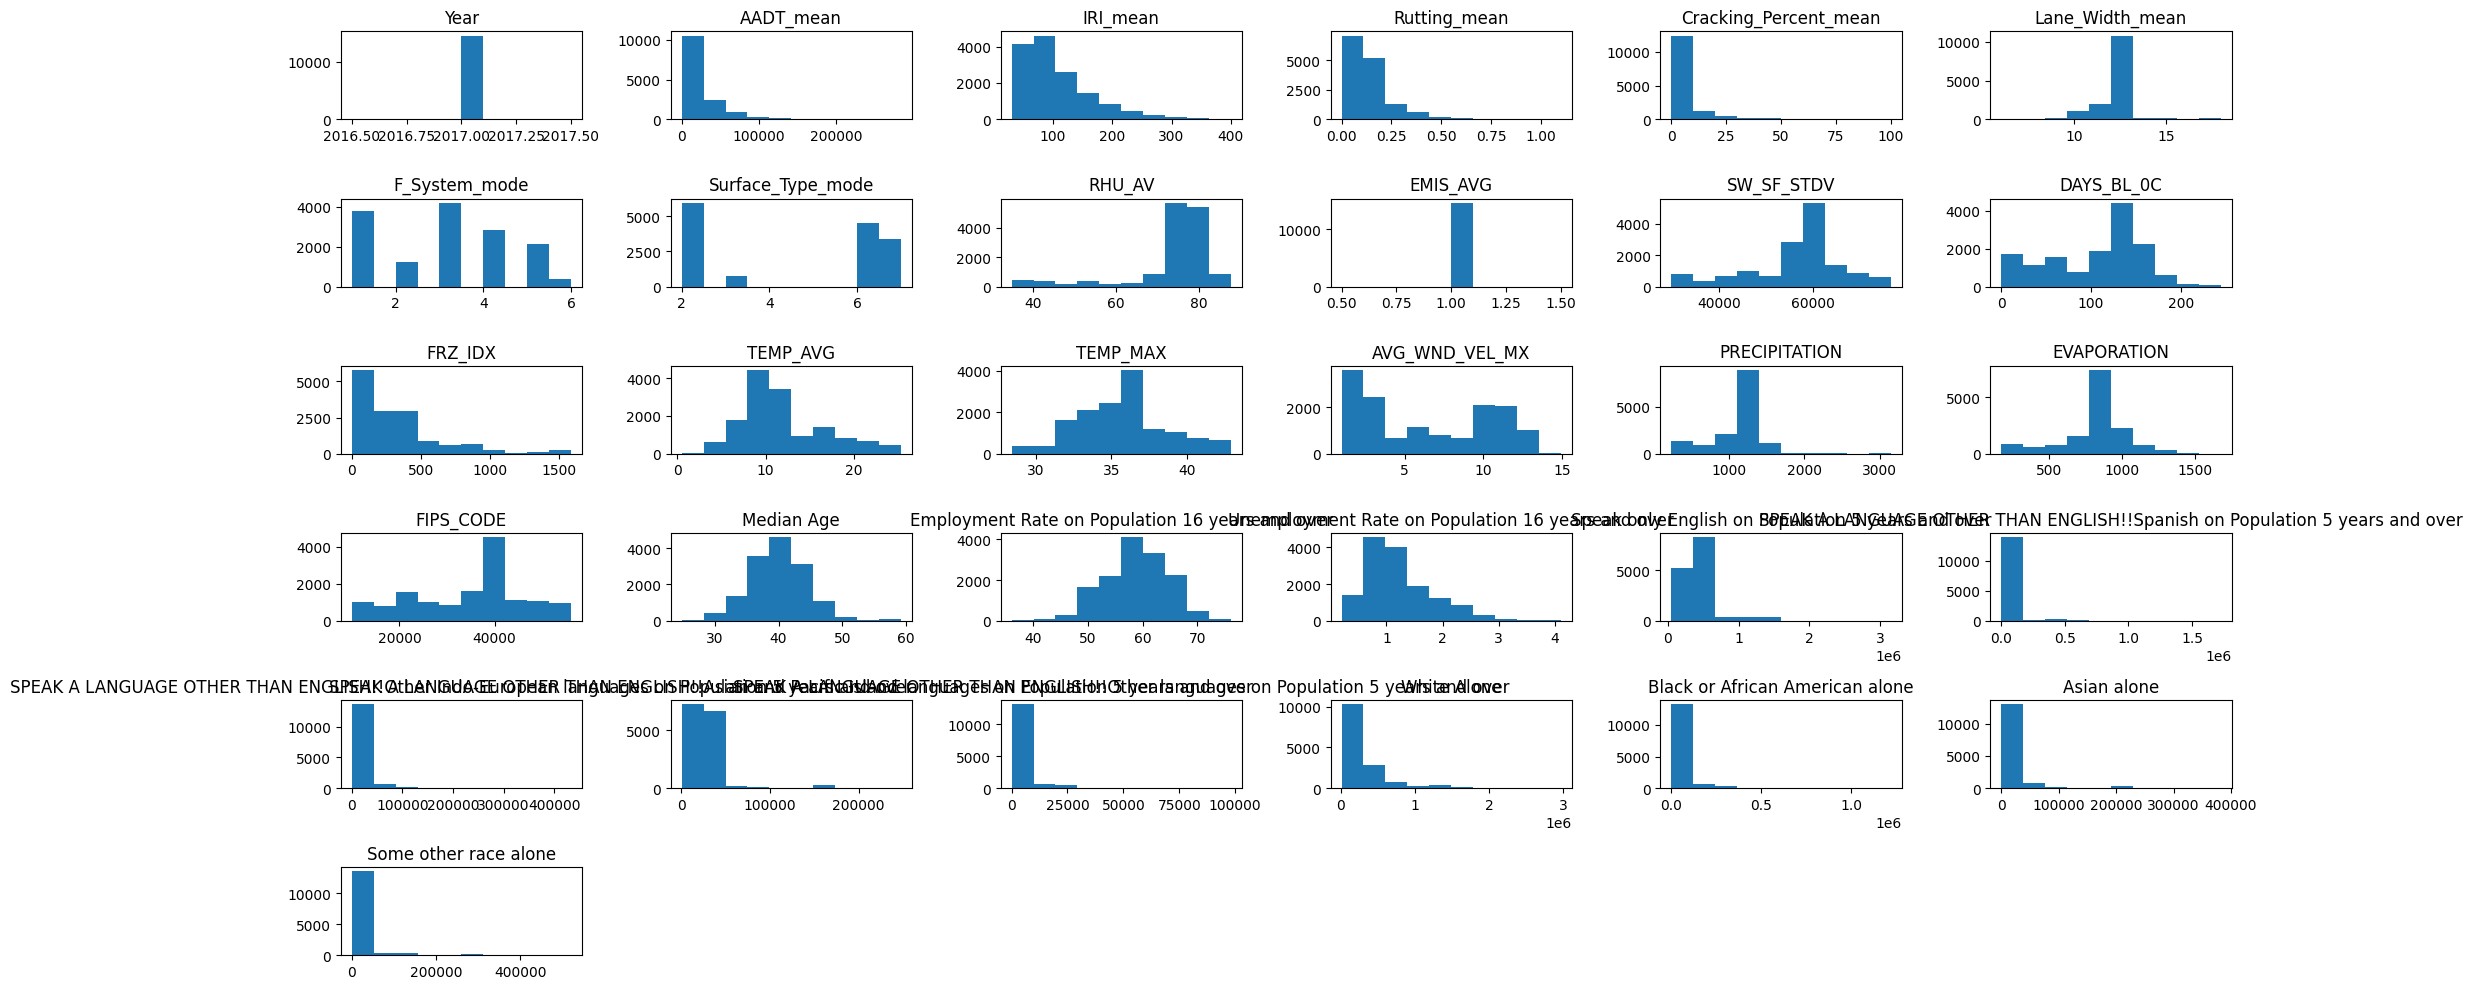

In [25]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
for i, feature in enumerate(df_2017.columns):
    ax = plt.subplot(6, 6, i + 1) #  you can have up to 6*6 = 36 individual subplots in total
    ax.hist(df_2017[feature])
    ax.set_title(feature)
plt.tight_layout()

In [26]:
## understand the distribution of data and indentifying the outliers
df_2017.describe()

Year      AADT_mean      IRI_mean  Rutting_mean  \
count  14584.0   14584.000000  14584.000000  14584.000000   
mean    2017.0   24998.454971    106.585457      0.169049   
std        0.0   30775.253523     59.552492      0.108743   
min     2017.0      15.000000     30.000000      0.000000   
25%     2017.0    5579.750000     63.500000      0.100000   
50%     2017.0   14984.500000     90.000000      0.167131   
75%     2017.0   31220.500000    133.000000      0.200000   
max     2017.0  283614.000000    400.000000      1.100000   

       Cracking_Percent_mean  Lane_Width_mean  F_System_mode  \
count           14584.000000     14584.000000   14584.000000   
mean                4.530609        11.851701       2.964756   
std                 9.551716         1.043084       1.465924   
min                 0.000000         6.000000       1.000000   
25%                 0.000000        12.000000       1.000000   
50%                 0.500000        12.000000       3.000000   
75%                 4.800000        12.000000       4.000000   
max               100.000000        18.000000       6.000000   

       Surface_Type_mode        RHU_AV  EMIS_AVG    SW_SF_STDV    DAYS_BL_0C  \
count       14584.000000  14584.000000   14584.0  14584.000000  14584.000000   
mean            4.450631     73.546470       1.0  56588.726051    104.745969   
std             2.194144     10.384962       0.0   9889.953966     53.282680   
min             2.000000     34.900000       1.0  29835.300000      0.000000   
25%             2.000000     73.800000       1.0  54444.900000     59.200000   
50%             6.000000     76.400000       1.0  58574.900000    123.600000   
75%             6.000000     78.100000       1.0  61030.800000    143.700000   
max             7.000000     87.600000       1.0  76690.500000    244.400000   

            FRZ_IDX      TEMP_AVG      TEMP_MAX  AVG_WND_VEL_MX  \
count  14584.000000  14584.000000  14584.000000    14584.000000   
mean     307.216792     11.799196     35.644853        6.354905   
std      325.138451      4.837129      2.867944        4.001018   
min        0.000000      0.500000     28.400000        1.000000   
25%       24.200000      8.700000     33.700000        2.400000   
50%      251.000000     10.500000     35.700000        5.400000   
75%      437.900000     14.400000     37.000000       10.400000   
max     1590.400000     25.300000     42.900000       14.900000   

       PRECIPITATION   EVAPORATION     FIPS_CODE    Median Age  \
count   14584.000000  14584.000000  14584.000000  14584.000000   
mean     1163.282306    821.136657  35180.185477     40.047326   
std       369.688874    222.055276  11644.369015      4.594565   
min       240.000000    173.700000  10001.000000     24.800000   
25%      1069.600000    765.600000  24021.000000     37.300000   
50%      1280.200000    860.300000  39089.000000     40.000000   
75%      1362.000000    911.400000  42107.000000     42.900000   
max      3145.300000   1671.400000  56025.000000     59.200000   

       Employment Rate on Population 16 years and over  \
count                                     14584.000000   
mean                                         58.787659   
std                                           5.774027   
min                                          36.100000   
25%                                          55.000000   
50%                                          58.900000   
75%                                          62.600000   
max                                          76.100000   

       Unemployment Rate on Population 16 years and over  \
count                                       14584.000000   
mean                                            1.226880   
std                                             0.617968   
min                                             0.200000   
25%                                             0.800000   
50%                                             1.100000   
75%                 

# Calculate IQR and Identify Outlier Thresholds

In [27]:
print(df_2017.shape)
df_2017.columns

(14584, 31)


Index(['Year', 'AADT_mean', 'IRI_mean', 'Rutting_mean',
       'Cracking_Percent_mean', 'Lane_Width_mean', 'F_System_mode',
       'Surface_Type_mode', 'RHU_AV', 'EMIS_AVG', 'SW_SF_STDV', 'DAYS_BL_0C',
       'FRZ_IDX', 'TEMP_AVG', 'TEMP_MAX', 'AVG_WND_VEL_MX', 'PRECIPITATION',
       'EVAPORATION', 'FIPS_CODE', 'Median Age',
       'Employment Rate on Population 16 years and over',
       'Unemployment Rate on Population 16 years and over',
       'Speak only English on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Spanish on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Other Indo-European languages on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Asian and Pacific Island languages on Population 5 years and over',
       'SPEAK A LANGUAGE OTHER THAN ENGLISH!!Other languages on Population 5 years and over',
       'White Alone', 'Black or African American alone', 'Asian alone',
       'Some other ra

<Axes: ylabel='AADT_mean'>

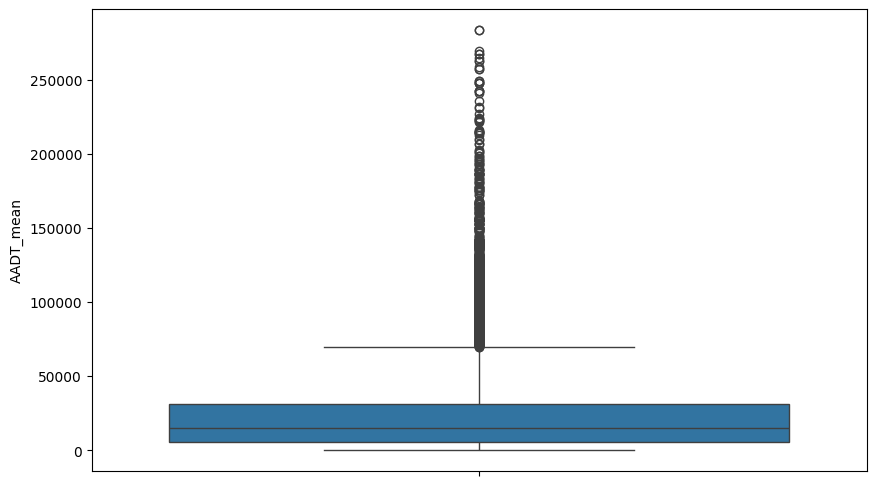

In [28]:
## Try boxplot
plt.figure(figsize= (10, 6))

sns.boxplot(df_2017['AADT_mean'])

In [29]:
## Calculate IQR
def calculate_IQR(df):
  Q1 = df.describe().loc['25%']
  Q3 = df.describe().loc['75%']
  IQR = Q3 - Q1
  print(IQR)

## Remove the outlier with this function IQR
def outlier_handles_with_IQR(df):

  # calculate IQR
  Q1 = df.describe().loc['25%']
  Q3 = df.describe().loc['75%']
  IQR = Q3 - Q1

  ## calculate the lower bound and upper bound
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  # Initialize a counter for outliers
  outlier_count = 0

  for col in df.columns:
    # Calculate the median for the current column
    # median couldn't remove much outliers, so use mean.

    mean = df[col].mean()

    # Iterate over each row for the current column
    for i in df.index:
      # Check if the current value is an outlier
        if df.at[i, col] < lower_bound[col] or df.at[i, col] > upper_bound[col]:
            # Print column, row, and outlier value
            print(f"Outlier found at column '{col}', row '{i}': {df.at[i, col]}")
            # Replace the outlier with the median
            df.at[i, col] = mean
            # Increment the outlier count
            outlier_count += 1

  # After replacing outliers, print the total count of outliers replaced
  print(f"Total outliers replaced: {outlier_count}")

## Remove the outlier with this function boxplot, taken from https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

def removal_box_plot(df, column, threshold):
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()

    outlier_indices = np.where(df[column] <= threshold)
    no_outliers = df.drop(outlier_indices[0])

    sns.boxplot(no_outliers[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    return no_outliers

In [30]:
calculate_IQR(df_2017)

Year                                                                                                           0.00
AADT_mean                                                                                                  25640.75
IRI_mean                                                                                                      69.50
Rutting_mean                                                                                                   0.10
Cracking_Percent_mean                                                                                          4.80
Lane_Width_mean                                                                                                0.00
F_System_mode                                                                                                  3.00
Surface_Type_mode                                                                                              4.00
RHU_AV                                                                  

In [31]:
calculate_IQR(df_2017['AADT_mean'])

25640.75


In [32]:
outlier_handles_with_IQR(df_2017)

Streaming output truncated to the last 5000 lines.
Outlier found at column 'Black or African American alone', row '78': 152183.0
Outlier found at column 'Black or African American alone', row '79': 152183.0
Outlier found at column 'Black or African American alone', row '80': 152183.0
Outlier found at column 'Black or African American alone', row '81': 152183.0
Outlier found at column 'Black or African American alone', row '82': 152183.0
Outlier found at column 'Black or African American alone', row '83': 152183.0
Outlier found at column 'Black or African American alone', row '84': 152183.0
Outlier found at column 'Black or African American alone', row '85': 152183.0
Outlier found at column 'Black or African American alone', row '86': 152183.0
Outlier found at column 'Black or African American alone', row '87': 152183.0
Outlier found at column 'Black or African American alone', row '88': 152183.0
Outlier found at column 'Black or African American alone', row '89': 152183.0
Outlier found

In [33]:
# outlier_handles_with_IQR(df_2017)

In [34]:
# outlier_handles_with_IQR(df_2017)

In [35]:
df_2017.shape
df_2017.to_csv('df_2017.csv')

<Axes: ylabel='AADT_mean'>

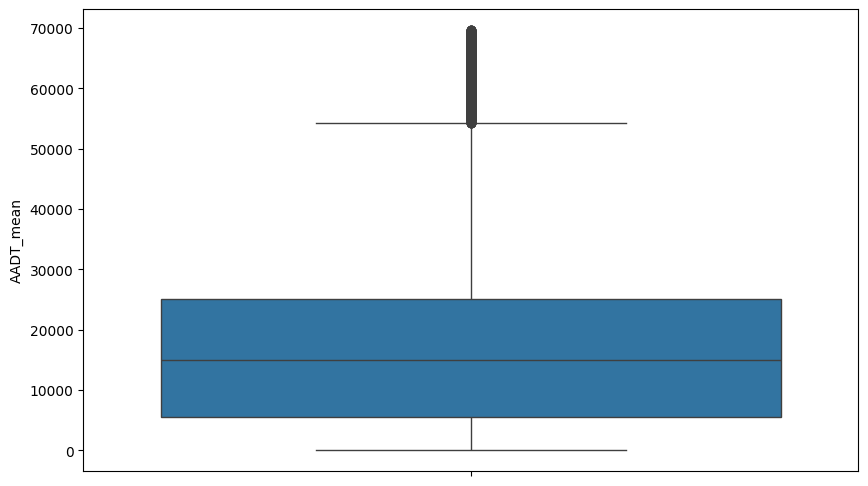

In [36]:
## check again boxplot

plt.figure(figsize= (10, 6))

sns.boxplot(df_2017['AADT_mean'])

In [37]:
df_2017.describe()

Year     AADT_mean      IRI_mean  Rutting_mean  \
count  14584.0  14584.000000  14584.000000  14584.000000   
mean    2017.0  18753.148718     99.323563      0.150011   
std        0.0  15976.680091     45.833428      0.073600   
min     2017.0     15.000000     30.000000      0.000000   
25%     2017.0   5579.750000     63.500000      0.100000   
50%     2017.0  14984.500000     90.000000      0.167131   
75%     2017.0  25043.750000    124.000000      0.200000   
max     2017.0  69647.000000    237.000000      0.300000   

       Cracking_Percent_mean  Lane_Width_mean  F_System_mode  \
count           14584.000000     14584.000000   14584.000000   
mean                2.075348        11.956692       2.964756   
std                 2.886858         0.067433       1.465924   
min                 0.000000        11.851701       1.000000   
25%                 0.000000        11.851701       1.000000   
50%                 0.500000        12.000000       3.000000   
75%                 4.530609        12.000000       4.000000   
max                12.000000        12.000000       6.000000   

       Surface_Type_mode        RHU_AV  EMIS_AVG    SW_SF_STDV    DAYS_BL_0C  \
count       14584.000000  14584.000000   14584.0  14584.000000  14584.000000   
mean            4.450631     76.400307       1.0  58124.878377    104.745969   
std             2.194144      3.216779       0.0   4534.047887     53.282680   
min             2.000000     67.500000       1.0  44656.000000      0.000000   
25%             2.000000     73.700000       1.0  56588.726051     59.200000   
50%             6.000000     76.300000       1.0  57905.500000    123.600000   
75%             6.000000     77.800000       1.0  60338.000000    143.700000   
max             7.000000     84.500000       1.0  70890.000000    244.400000   

            FRZ_IDX      TEMP_AVG      TEMP_MAX  AVG_WND_VEL_MX  \
count  14584.000000  14584.000000  14584.000000    14584.000000   
mean     270.242448     11.424459     35.640917        6.354905   
std      253.831921      4.332712      2.814057        4.001018   
min        0.000000      0.500000     29.100000        1.000000   
25%       24.200000      8.700000     33.700000        2.400000   
50%      251.000000     10.500000     35.700000        5.400000   
75%      393.300000     13.500000     36.900000       10.400000   
max     1003.100000     22.800000     41.900000       14.900000   

       PRECIPITATION   EVAPORATION     FIPS_CODE    Median Age  \
count   14584.000000  14584.000000  14584.000000  14584.000000   
mean     1231.390473    854.969422  35180.185477     39.963384   
std       175.504497     95.398326  11644.369015      4.157967   
min       650.100000    569.000000  10001.000000     28.900000   
25%      1163.282306    819.000000  24021.000000     37.400000   
50%      1269.400000    840.200000  39089.000000     40.047326   
75%      1358.900000    900.400000  42107.000000     42.700000   
max      1670.200000   1127.500000  56025.000000     50.800000   

       Employment Rate on Population 16 years and over  \
count                                     14584.000000   
mean                                         58.898568   
std                                           5.410318   
min                                          43.700000   
25%                                          55.175000   
50%                                          58.900000   
75%                                          62.600000   
max                                          73.400000   

       Unemployment Rate on Population 16 years and over  \
count                                       14584.000000   
mean                                            1.162648   
std                                             0.504655   
min                                             0.200000   
25%                                             0.800000   
50%                                             1.100000   
75%                          

In [38]:
df_2017.shape

(14584, 31)

In [39]:
print(df_2017.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14584 entries, 0 to 14583
Data columns (total 31 columns):
 #   Column                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                  --------------  -----  
 0   Year                                                                                                    14584 non-null  int64  
 1   AADT_mean                                                                                               14584 non-null  float64
 2   IRI_mean                                                                                                14584 non-null  float64
 3   Rutting_mean                                                                                            14584 non-null  float64
 4   Cracking_Percent_mean                                                                   

In [40]:
## see pairwise distrbution of data
# sns.pairplot(df_2017)
# plt.show()

# Read
source: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

# Step-2: Standardizing the data

In [41]:
scaler = StandardScaler()

# Fit on training set only
scaler.fit(df_2017)
print(df_2017.shape)

(14584, 31)


Using Pairplots for better understanding of the data points distribution

# Step 2: Pre-clustering using K-Means

Understand KMeans Clustering from here:
https://github.com/alexandrehsd/Cluster-Analysis/blob/master/Cluster%20Analysis.ipynb

See this vidoe for better understanding: https://www.youtube.com/watch?v=4b5d3muPQmA

 The K-means algorithm performs the following steps:

1. Choose the number (K) of clusters
2. Specify the cluster seeds (Define the initial position of the centroids)
Here, you can create a range of cluster numbers and use loop to find the best answers.
3. Assign each point to a centroid based on its proximity (if the centroid
 is the nearest centroid to the point, then assign to , do this for all points)
4. Adjust the centroid (recalculate the position of each centroid based in the points assigned to them)
5. Repeat step 3 and 4, until achieving a stop criterion
6. After achieve a stop criteria, end execution.

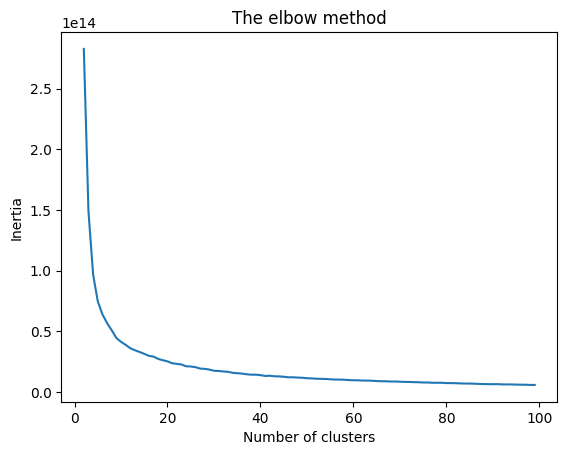

In [42]:
# Finding the optimal number of clusters for K-Means using Elbow Method
# source: https://medium.com/mlearning-ai/elbow-method-vs-silhouette-co-efficient-in-determining-the-number-of-clusters-33baff2fbeee

# step-1: initialize some number of clusters
inertia = []

for n_clusters in range(2,100):
  # The KMeans will find the optimalnumber of clusters using the metric value.
  kmeans_model = KMeans(n_clusters=n_clusters, init = 'k-means++',
                    max_iter = 300, n_init = 10, random_state=0)

  kmeans_model.fit(df_2017)
  inertia.append(kmeans_model.inertia_)

# Plotting the results onto a line graph,
# `allowing us to observe 'The elbow'
plt.plot(range(2, 100), inertia)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')  # Correcting the label to 'Inertia'
plt.show()

# guide source: https://www.kaggle.com/code/dhanyajothimani/basic-visualization-and-clustering-in-python


In [43]:
# Applying K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=22, random_state=42)
cluster_labels = kmeans.fit_predict(df_2017)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
silhouette_avg = silhouette_score(df_2017, cluster_labels)
print(f"The average silhouette score: {silhouette_avg}")

The average silhouette score: 0.3693487919687011


In [45]:
kmeans.labels_

array([ 8,  8,  8, ..., 16, 16, 16], dtype=int32)

In [46]:
kmeans.cluster_centers_

array([[  2017.        ,  29678.98684476,     89.25100989,
             0.14649834,      1.72137763,     11.96281721,
             2.30612245,      4.36443149,     76.24169096,
             1.        ,  58617.20375833,    102.14285714,
           244.29883382,     12.48688047,     35.20233236,
             5.5154519 ,   1285.4122449 ,    837.557248  ,
         40305.        ,     39.81953353,     61.10670554,
             0.65510204, 389025.33569038,  17242.60932945,
         23864.89173446,  16143.11953353,   6949.1243463 ,
        295203.67912037,  54420.38679555,  16190.17621692,
          5994.4414015 ],
       [  2017.        ,  13302.05701833,     92.3364125 ,
             0.15948015,      1.96794301,     11.96078541,
             2.93691275,      4.40973154,     76.49788099,
             1.        ,  58640.46236018,    118.16096035,
           286.5525101 ,     10.31143265,     35.15698351,
             6.35554678,   1201.28352828,    833.70573999,
         36080.51107383,     4

In [47]:
kmeans_data_cluster = pd.DataFrame(cluster_labels)
kmeans_data_cluster.head(10)

0
0   8
1   8
2   8
3   8
4  16
5  16
6   1
7   1
8   1
9  10

In [48]:
df_2017.insert((df_2017.shape[1]),'kmeans_data_cluster',kmeans_data_cluster)

visualize the clusters

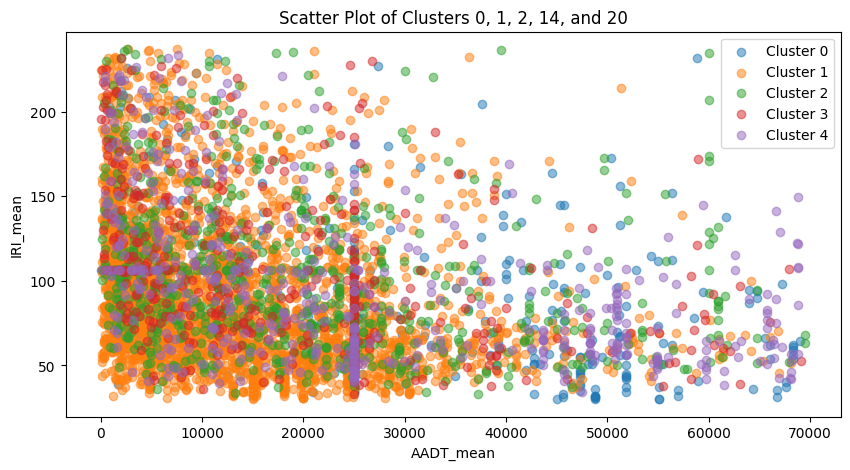

In [49]:
# Assuming 'ColumnX' and 'ColumnY' are the names of the columns you want to plot
column_x = df_2017.columns[1]  # Replace with your actual column name or index
column_y = df_2017.columns[2]  # Replace with your actual column name or index

# Start a new figure
plt.figure(figsize=(10, 5))

# Filter the dataframe for cluster 0 and plot
cluster_0 = df_2017[df_2017['kmeans_data_cluster'] == 0]
plt.scatter(cluster_0[column_x], cluster_0[column_y], alpha=0.5, label='Cluster 0')

# Filter the dataframe for cluster 1 and plot
cluster_1 = df_2017[df_2017['kmeans_data_cluster'] == 1]
plt.scatter(cluster_1[column_x], cluster_1[column_y], alpha=0.5, label='Cluster 1')

# Filter the dataframe for cluster 2 and plot
cluster_2 = df_2017[df_2017['kmeans_data_cluster'] == 2]
plt.scatter(cluster_2[column_x], cluster_2[column_y], alpha=0.5, label='Cluster 2')

# Filter the dataframe for cluster 14 and plot
cluster_3 = df_2017[df_2017['kmeans_data_cluster'] == 3]
plt.scatter(cluster_3[column_x], cluster_3[column_y], alpha=0.5, label='Cluster 3')

# Filter the dataframe for cluster 20 and plot
cluster_4= df_2017[df_2017['kmeans_data_cluster'] == 4]
plt.scatter(cluster_4[column_x], cluster_4[column_y], alpha=0.5, label='Cluster 4')

# Add the legend, title, and labels
plt.legend()
plt.title('Scatter Plot of Clusters 0, 1, 2, 14, and 20')
plt.xlabel(column_x)
plt.ylabel(column_y)
plt.show()


In [50]:
clusterd_data = df_2017.groupby('kmeans_data_cluster').mean()
clusterd_data

Year     AADT_mean    IRI_mean  Rutting_mean  \
kmeans_data_cluster                                                   
0                    2017.0  29678.986845   89.251010      0.146498   
1                    2017.0  13288.156452   92.373072      0.159520   
2                    2017.0  18585.866828  101.983336      0.139245   
3                    2017.0  17798.525155  108.700929      0.122235   
4                    2017.0  26041.177944   97.215042      0.138414   
5                    2017.0  22478.044241   98.882656      0.161983   
6                    2017.0  22984.984230  106.888953      0.144787   
7                    2017.0  19864.288263  101.088274      0.168554   
8                    2017.0  19507.777854   99.508781      0.136310   
9                    2017.0  22208.047727   88.127606      0.158207   
10                   2017.0  19840.775013  109.512672      0.117431   
11                   2017.0  25216.743338   94.088157      0.156334   
12                   2017.0  25134.020536   87.404032      0.108247   
13                   2017.0  19503.069223  107.983632      0.118128   
14                   2017.0  31981.203657   96.032522      0.124001   
15                   2017.0  18498.816150  113.240969      0.144625   
16                   2017.0  16120.029165   93.915237      0.164589   
17                   2017.0  20183.953655  108.332023      0.163203   
18                   2017.0  13817.017061  110.278557      0.135432   
19                   2017.0  19247.572939  109.586053      0.152038   
20                   2017.0  23999.478673  115.913989      0.106122   
21                   2017.0  16390.470358  100.421437      0.146064   

                     Cracking_Percent_mean  Lane_Width_mean  F_System_mode  \
kmeans_data_cluster                                                          
0                                 1.721378        11.962817       2.306122   
1                                 1.968526        11.960759       2.938214   
2                                 1.813731        11.958977       3.161567   
3                                 3.081801        11.935052       3.574209   
4                                 1.517524        11.965875       2.705376   
5                                 2.175914        11.962081       2.648101   
6                                 1.439617        11.952207       2.478673   
7                                 2.144186        11.953151       2.932636   
8                                 1.991806        11.954662       2.901381   
9                                 2.174655        11.972325       2.876761   
10                                1.758723        11.945267       3.390519   
11                                2.558582        11.964550       2.669323   
12                                1.717938        11.973134       2.775362   
13                                1.684097        11.940680       3.147368   
14                                2.452668        11.978417       2.211268   
15                                3.832204        11.947680       3.182243   
16                                1.954737        11.963608       2.919285   
17                                2.299948        11.951979       3.220106   
18                                3.697716        11.911948       3.493750   
19                                1.860590        11.949361       3.164634   
20                                0.763890        11.987894       2.693878   
21                                1.874998        11.943108       3.056266   

                     Surface_Type_mode     RHU_AV  EMIS_AVG    SW_SF_STDV  \
kmeans_data_cluster                                                         
0                             4.364431  76.241691       1.0  58617.203758   
1                             4.411350  76.501372       1.0  58642.537285   
2                             4.758874  76.703692       1.0  58627.862349   
3                             4.043796  75.708232       1.0 

# profile a cluster using pandas to get the mean values for each column


<Axes: >

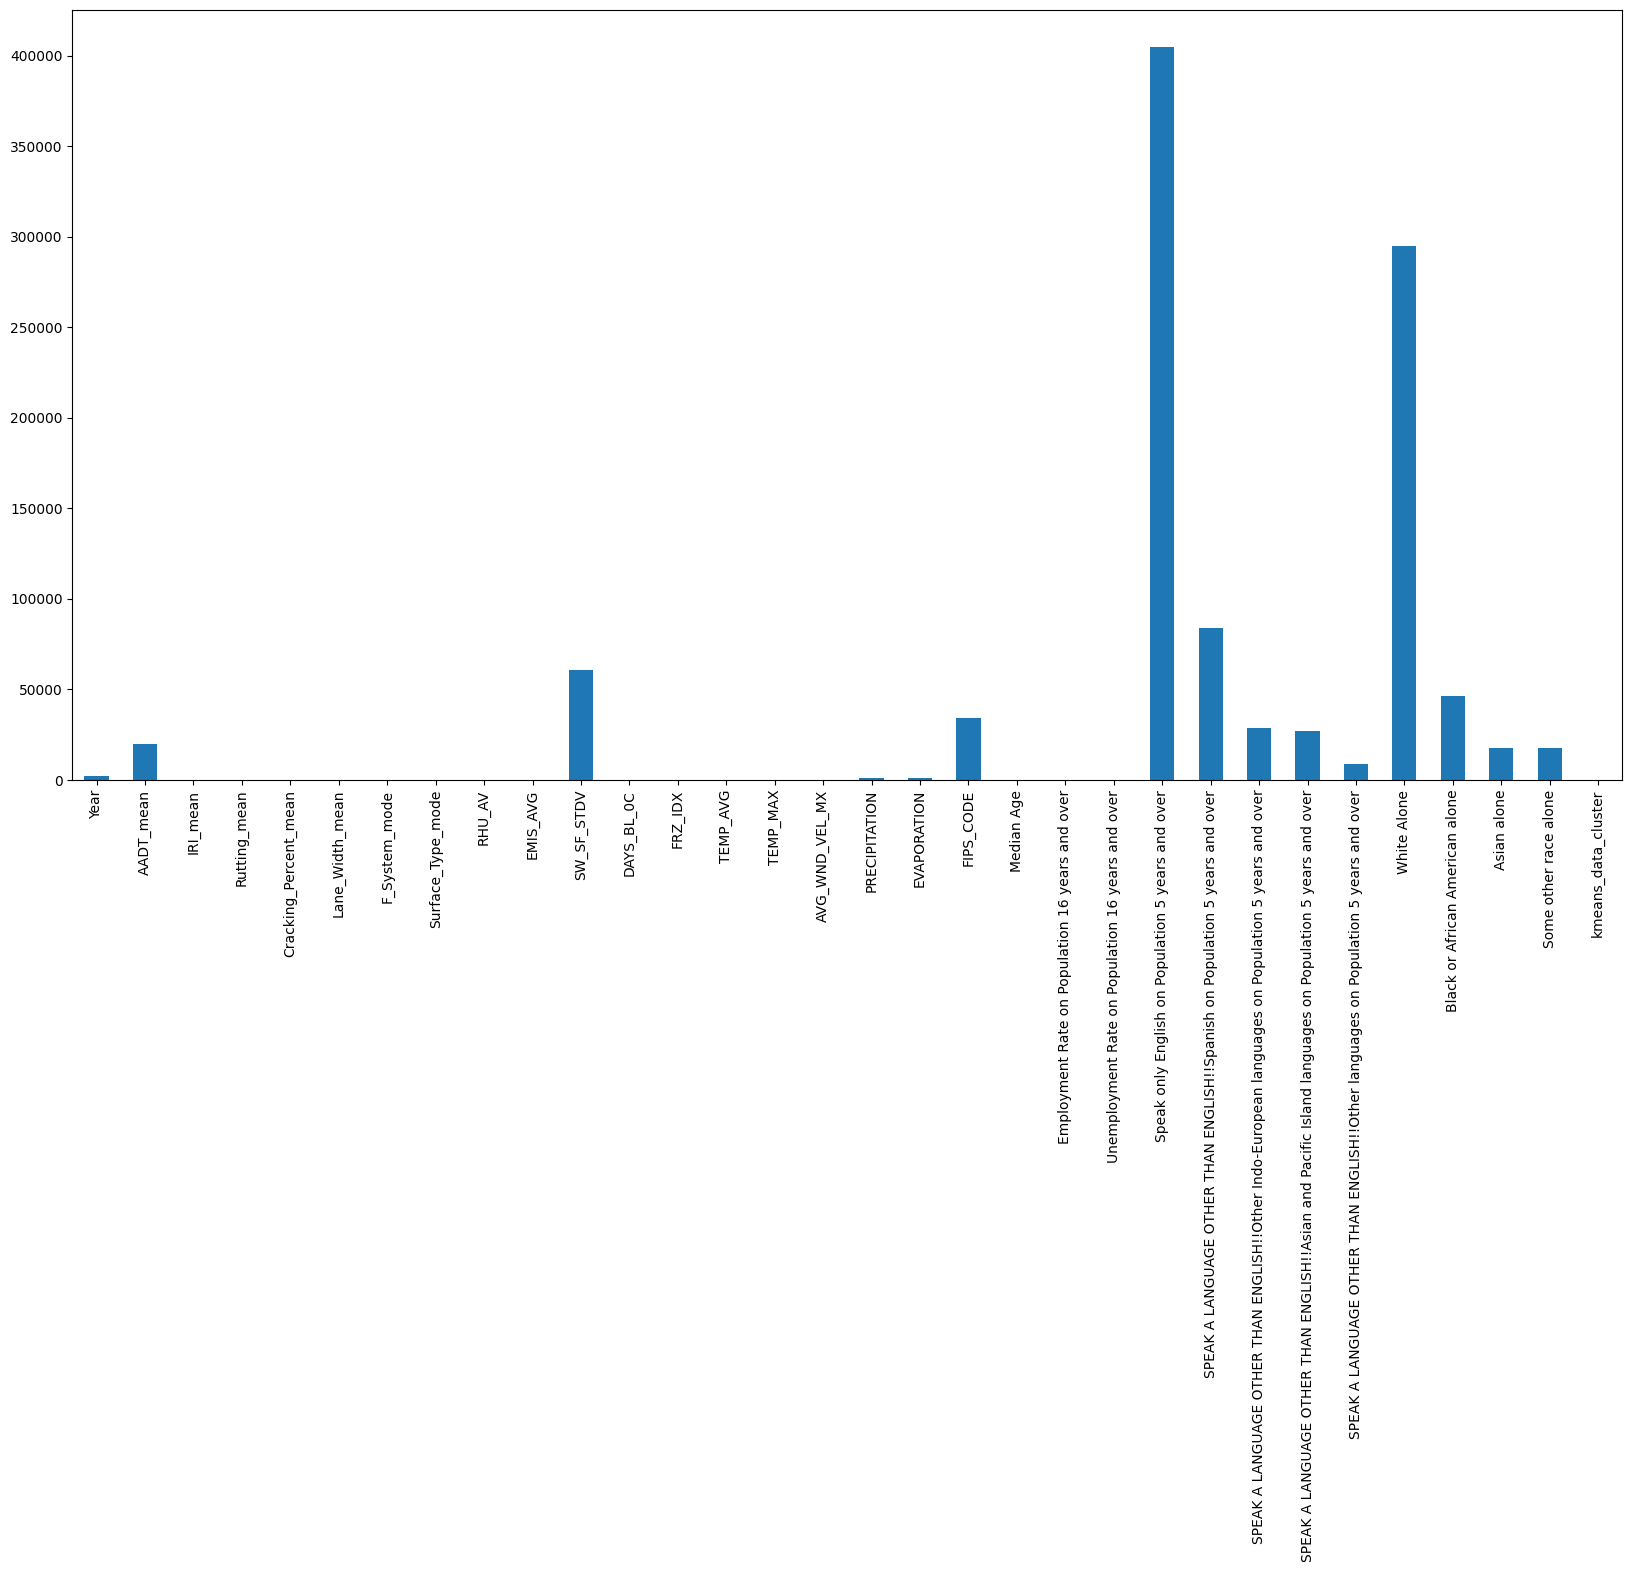

In [51]:
# profile a cluster using pandas to get the mean values for each column

cluster_number = 10  # Replace with your desired cluster number

# Filter the dataframe for the chosen cluster
cluster_df = df_2017[df_2017['kmeans_data_cluster'] == cluster_number]

# Calculate mean values for each column within the cluster
cluster_profile = cluster_df.mean()

# You might also want to compare these means to the overall means
overall_means = df_2017.mean()

# Now you can print or plot these to see which columns have high values for this cluster

cluster_profile.plot(kind='bar', figsize=(20,10))


# Social Factors by IRI_mean

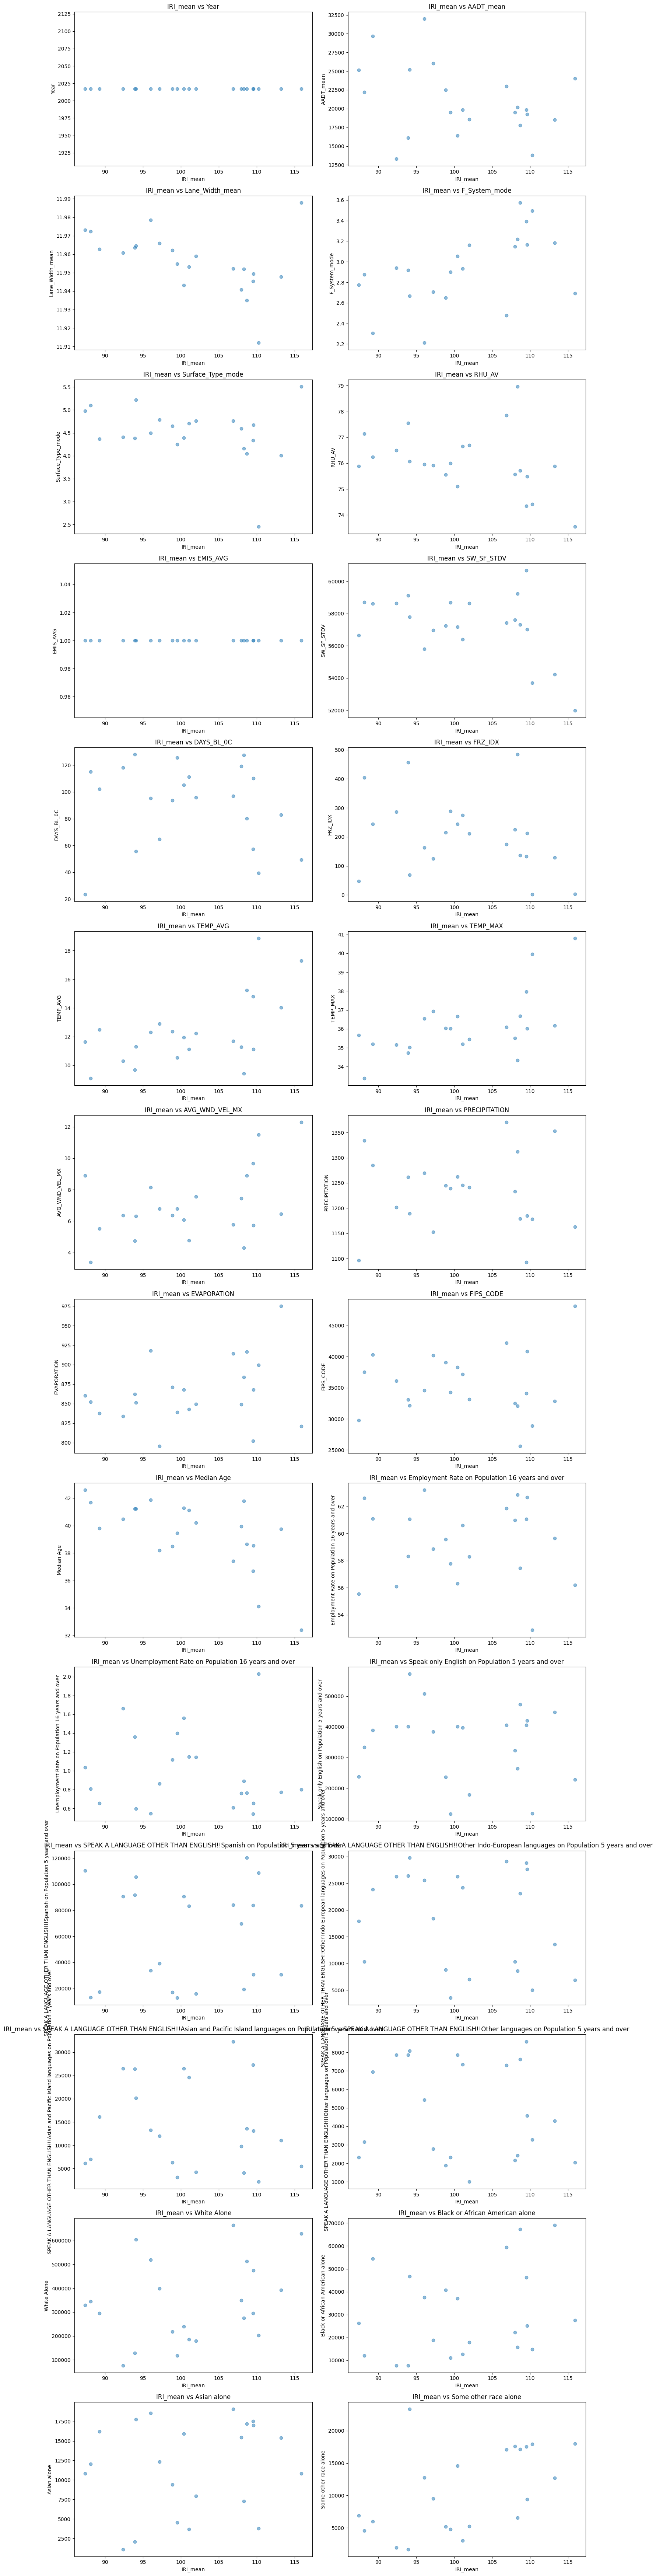

In [52]:
# List of columns to exclude from the plots (e.g., non-numerical or not relevant for comparison)
exclude_columns = ['IRI_mean', 'Rutting_mean','Cracking_Percent_mean']

# Ensure only numerical columns are considered for Y-axis
y_columns = [col for col in clusterd_data.columns if col not in exclude_columns and clusterd_data[col].dtype in ['float64', 'int64']]

# Number of Y columns
n_plots = len(y_columns)

# Calculate number of rows and columns for subplots
n_cols = 2  # For two columns in each row
n_rows = (n_plots + 1) // n_cols  # Calculate rows needed

# Creating figure and axes for subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
axs = axs.flatten()  # Flatten to 1D array for easy indexing

# Loop through all Y columns to plot
for i, y_column in enumerate(y_columns):
    ax = axs[i]
    ax.scatter(clusterd_data['IRI_mean'], clusterd_data[y_column], alpha=0.5)
    ax.set_xlabel('IRI_mean')
    ax.set_ylabel(y_column)
    ax.set_title(f'IRI_mean vs {y_column}')

# Hide any unused subplots if number of plots is not exactly divisible by n_cols
for j in range(i+1, n_rows*n_cols):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()



# Step 3: Hierarchical Clustering

In [53]:
# Step 2: Hierarchical clustering on the centroids of pre-clusters

from scipy.cluster.hierarchy import dendrogram, linkage

centroids = kmeans.cluster_centers_
Z = linkage(centroids, 'ward')

In [54]:
Z.labels_

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

we can use axline to see how many lines get intersect on denrogram for clsuters. But we have already number of clusters from KMeans. So the same number for agglomerative clusters

In [ ]:
# Plotting dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z)
plt.show()

In [ ]:
import numpy as np

def get_cluster_elements(Z, num_clusters):
    """
    Retrieves the elements of each cluster from the linkage matrix Z.

    :param Z: Linkage matrix returned by the linkage function from scipy.cluster.hierarchy.
    :param num_clusters: The original number of clusters before hierarchical clustering.
    :return: A dictionary mapping the cluster index to the original elements it contains.
    """
    # Initialize a dictionary to store the elements of each cluster
    cluster_dict = {i: [i] for i in range(num_clusters)}

    # Number of original elements
    n = Z.shape[0] + 1

    # Iterate over each merge operation
    for i, merge in enumerate(Z):
        # Get the indices of the clusters being merged
        idx1, idx2 = int(merge[0]), int(merge[1])

        # If the index is less than the number of original clusters, it is an original element.
        # If it is greater or equal, it is a cluster formed during the process.
        # Merge the clusters/elements together in the dictionary.
        cluster_dict[n + i] = cluster_dict.get(idx1, []) + cluster_dict.get(idx2, [])

        # Once we have only one cluster left, we can stop (optional)
        if len(cluster_dict[n + i]) == num_clusters:
            break

    return cluster_dict

# Example usage:
# Assuming Z is your linkage matrix and you have 42 original clusters (centroids from K-Means)
#Z = linkage(centroids, 'ward')
cluster_elements = get_cluster_elements(Z, num_clusters=42)

# Print the clusters and their elements
for cluster, elements in cluster_elements.items():
    print(f"Cluster {cluster}: {elements}")
